<h1>Traffic Signs Classification</h1>
<p>Using German Traffic Sign Dataset (http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). You can download the from <a href="https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip"> here</a></p>

<h1>Imports</h1>

In [1]:
import matplotlib.pyplot as plt
import random as rn
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
from keras.models import Sequential
from keras.layers import Dense, Input, Activation
from keras.utils import np_utils
%matplotlib inline

Using TensorFlow backend.


<h1>Loading the Data</h1>

In [2]:
train_data = 'data/train.p'
test_data = 'data/test.p'

with open(train_data, 'rb') as f:
    train = pickle.load(f)

with open(test_data, 'rb') as f:
    test = pickle.load(f)

<h1>Data Info</h1>
<p>Spliting the train data as train and validation set</p>

In [3]:
X_train, X_val, Y_train, Y_val = train_test_split(train['features'], train['labels'], test_size=0.3, random_state=0)
X_test, Y_test = test['features'], test['labels']

n_train = X_train.shape[0]
n_val = X_val.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1], X_train.shape[2]
n_channels = X_train.shape[3]
n_classes = np.unique(train['labels']).size

print('Train data size:\t\t\t', n_train)
print('Validation data size:\t\t\t', n_val)
print('test data size:\t\t\t\t', n_test)
print('Image shape:\t\t\t\t', image_shape)
print('Number of color channels in image:\t', n_channels)
print('Number of classes:\t\t\t', n_classes)

Train data size:			 27446
Validation data size:			 11763
test data size:				 12630
Image shape:				 (32, 32)
Number of color channels in image:	 3
Number of classes:			 43


<h2>Reshape All the Data</h2>

In [4]:
def reshape(arr):
    return arr.reshape(-1, image_shape[0]*image_shape[1]*n_channels)

X_train_flat = reshape(X_train)
X_val_flat = reshape(X_val)
X_test_flat = reshape(X_test)

def print_info(st, arr_1, arr_2):
    print('{} data shape before reshape: {}, and after reshape: {}'.format(st, arr_1.shape, arr_2.shape))

print_info('Train', X_train, X_test_flat)
print_info('Validation', X_val, X_val_flat)
print_info('Test', X_test, X_test_flat)

Train data shape before reshape: (27446, 32, 32, 3), and after reshape: (12630, 3072)
Validation data shape before reshape: (11763, 32, 32, 3), and after reshape: (11763, 3072)
Test data shape before reshape: (12630, 32, 32, 3), and after reshape: (12630, 3072)


<h2>Data Normalization</h2>
<p>Process all the data as close as mean 0.0 and standard deviation 1.0.</p>

In [5]:
def normalize(arr):
    arr = arr.astype('float32')
    return (arr - np.mean(arr))/np.std(arr)

X_train_norm = normalize(X_train_flat)
X_val_norm = normalize(X_val_flat)
X_test_norm = normalize(X_test_flat)

def print_info(st, arr_1, arr_2):
    print('{} Data: Before normalization : type: {}, mean: {}, std: {}. After processing, type: {}, mean: {}, std: {}'. format(st, arr_1.dtype, round(np.mean(arr_1),2), round(np.std(arr_1),2), arr_2.dtype, round(np.mean(arr_2),2), round(np.std(arr_2),2)))

print_info('Train', X_train_flat, X_train_norm)
print_info('Valdation', X_val_flat, X_val_norm)
print_info('Test', X_test_flat, X_test_norm)

Train Data: Before normalization : type: uint8, mean: 82.54, std: 68.96. After processing, type: float32, mean: 0.0, std: 1.0
Valdation Data: Before normalization : type: uint8, mean: 82.95, std: 69.22. After processing, type: float32, mean: -0.0, std: 1.0
Test Data: Before normalization : type: uint8, mean: 82.15, std: 68.74. After processing, type: float32, mean: -0.0, std: 1.0


<p>Convert all the classes as one hot encode.</p>

In [6]:
def make_categorical(arr):
    return np_utils.to_categorical(arr, n_classes)

Y_train_cat = make_categorical(Y_train)
Y_val_cat = make_categorical(Y_val)
Y_test_cat = make_categorical(Y_test)

<h2>Some Random Image</h2>
<p>Before normalization</p>

In [7]:
trc = rn.sample(range(n_test), 16)

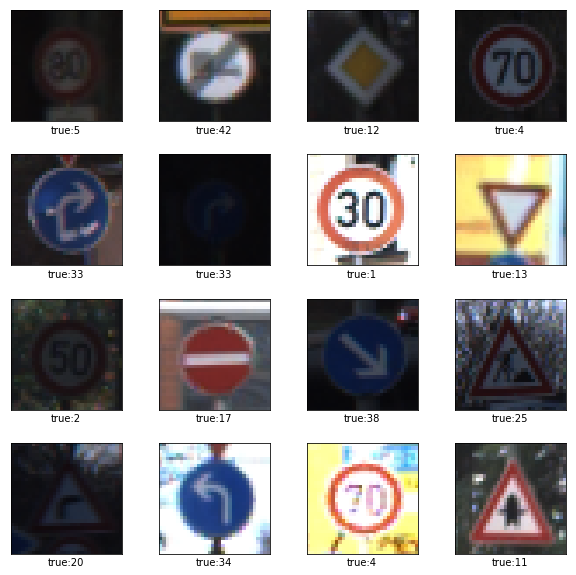

In [8]:
def plot_images(arr_1, arr_2, pred=False):
    fig, axes = plt.subplots(4, 4, figsize=(10,10))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        if len(arr_1.shape) == 2:
            ax.imshow(arr_1[trc[i]].reshape(32,32,3))
            ax.set_xlabel('true:{}'.format(arr_2[trc[i]]))
        else:
            ax.imshow(arr_1[trc[i]])
            ax.set_xlabel('true:{}, pred:{}'.format(arr_2[trc[i]], pred[trc[i]]))
        ax.set_xticks([])
        ax.set_yticks([])
        
plot_images(X_train_flat, Y_train)

<p>After normalization</p>

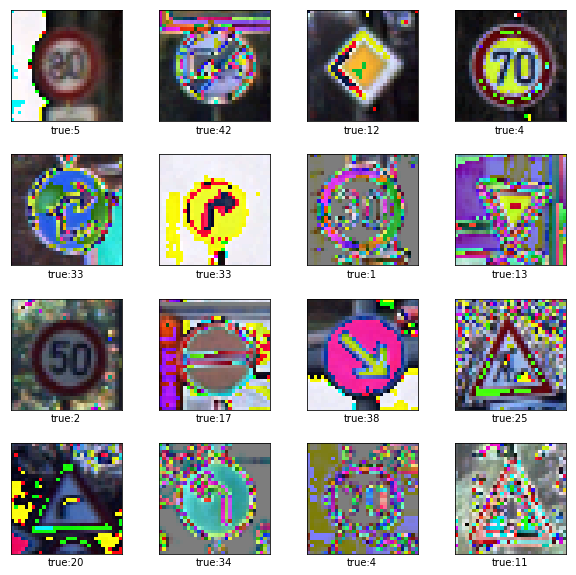

In [9]:
plot_images(X_train_norm, Y_train)

<h2>Build the Model in Keras</h2>

In [10]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(32*32*3,)))
#model.add(Dense(800, activation='relu',input_shape=(1555,)))
model.add(Dense(43, activation='softmax'))

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               786688    
_________________________________________________________________
dense_2 (Dense)              (None, 43)                11051     
Total params: 797,739
Trainable params: 797,739
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
history = model.fit(X_train_norm, Y_train_cat, batch_size=64, epochs=20, verbose=1, validation_data=(X_val_norm, Y_val_cat))

Train on 27446 samples, validate on 11763 samples
Epoch 1/20
27446/27446 [==============================] - 26s - loss: 1.4760 - acc: 0.6421 - val_loss: 0.8854 - val_acc: 0.7697
Epoch 2/20
27446/27446 [==============================] - 22s - loss: 0.6595 - acc: 0.8222 - val_loss: 0.6247 - val_acc: 0.8409
Epoch 3/20
27446/27446 [==============================] - 23s - loss: 0.4903 - acc: 0.8703 - val_loss: 0.4924 - val_acc: 0.8619
Epoch 4/20
27446/27446 [==============================] - 23s - loss: 0.3866 - acc: 0.8958 - val_loss: 0.4128 - val_acc: 0.8822
Epoch 5/20
27446/27446 [==============================] - 22s - loss: 0.3499 - acc: 0.9058 - val_loss: 0.4449 - val_acc: 0.8799
Epoch 6/20
27446/27446 [==============================] - 22s - loss: 0.3338 - acc: 0.9123 - val_loss: 0.4354 - val_acc: 0.8885
Epoch 7/20
27446/27446 [==============================] - 21s - loss: 0.3056 - acc: 0.9197 - val_loss: 0.4780 - val_acc: 0.8843
Epoch 8/20
27446/27446 [==============================

In [ ]:
history.history['val_acc'][-1]

0.91634787046654964

In [ ]:
cnt = 0
Y_pred = []
for i in range(n_test):
    arr = X_test[i].reshape(-1, 32*32*3)
    arr = normalize(arr)
    r = model.predict(arr)
    Y_pred.append(r.argmax())
    if r.argmax() != Y_test[i]:
        cnt += 1
Y_pred = np.asarray(Y_pred)
print('Mismatch: ', cnt)
print('Test Acc: ', 1-cnt/n_test)

In [ ]:
plot_images(X_test, Y_test, Y_pred)

In [ ]:
score, acc = model.evaluate(X_test_norm, Y_test_cat, batch_size=64, verbose=1)

In [ ]:
print('Score: ', score)
print('Acc: ', acc)